# XGBoost
#### Holden Bruce

The data contains 5822 real customer records. Each record consists of 86 variables, containing sociodemographic data (variables 1-43) and product ownership (variables 44-86). The sociodemographic data is derived from zip codes. All customers living in areas with the same zip code have the same sociodemographic attributes. Variable 86 (Purchase) indicates whether the customer purchased a caravan insurance policy. Further information on the individual variables can be obtained at http://www.liacs.nl/~putten/library/cc2000/data.html

In this question, we will be building a collection of boosted trees and using the categorical/continuous data from the caravan dataset to 
predict whether or not a person will make a purchase if the estimated probability of purchase is greater than 20%. We will then compare the results to KNN and logistic regression for this same dataset, ultimatley showing that XGBoost leads to a better predictive model. XGBoost is particularly useful as a machine learning method enabling us to create a relatively easily interpretable model without sacrificing our ability to correctly classify observations.

We'll start with loading the caravan dataset using pandas to turn it into a dataframe, which we will call 'caravan'

In [18]:
import numpy as np # calculate the mean and standard deviation
import matplotlib.pyplot as plt # to draw graphs
from sklearn.tree import DecisionTreeClassifier # to build a classification tree
from sklearn.tree import DecisionTreeRegressor # to build a regression tree
from sklearn.tree import plot_tree # to draw a classification tree
import graphviz
from sklearn.tree import export_graphviz # to export a tree using graphviz
#conda install -c conda-forge xgboost
import xgboost as xgb # XGBoost 
from sklearn.model_selection import train_test_split # split data into training and testing sets
from sklearn.model_selection import cross_val_score # for cross validation
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # for scoring during cross validation
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import mean_squared_error # calculates mse
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,GradientBoostingClassifier

In [20]:
caravan = pd.read_csv('Caravan.csv')

Then we'll check the first five rows using head() and .shape to get an understanding of the layout (how many predictors and rows we have)

In [21]:
caravan.head()
caravan.shape #(5822, 86)

(5822, 86)

We have 86 columns (85 predictors) and 5822 rows (individual customer records)

In [22]:
#use .info() function to get a better sense of the type of data in 
#this dataset
caravan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 86 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   MOSTYPE   5822 non-null   int64 
 1   MAANTHUI  5822 non-null   int64 
 2   MGEMOMV   5822 non-null   int64 
 3   MGEMLEEF  5822 non-null   int64 
 4   MOSHOOFD  5822 non-null   int64 
 5   MGODRK    5822 non-null   int64 
 6   MGODPR    5822 non-null   int64 
 7   MGODOV    5822 non-null   int64 
 8   MGODGE    5822 non-null   int64 
 9   MRELGE    5822 non-null   int64 
 10  MRELSA    5822 non-null   int64 
 11  MRELOV    5822 non-null   int64 
 12  MFALLEEN  5822 non-null   int64 
 13  MFGEKIND  5822 non-null   int64 
 14  MFWEKIND  5822 non-null   int64 
 15  MOPLHOOG  5822 non-null   int64 
 16  MOPLMIDD  5822 non-null   int64 
 17  MOPLLAAG  5822 non-null   int64 
 18  MBERHOOG  5822 non-null   int64 
 19  MBERZELF  5822 non-null   int64 
 20  MBERBOER  5822 non-null   int64 
 21  MBERMIDD  5822

This shows us that every column is of type int64 except for Purchase, the response variable, which is of type object.

In [23]:
#check for missing data
col_names = list(caravan.columns)
for name in col_names:
    if len(caravan.loc[caravan[name]==' ']) > 0:
        print(name)
#none

Now we'll split the data into X (predictors) and y (response). We want to predict whether the customer purchased a caravan insurance 
policy (Purchase), using the other 85 columns as predictors.
<br><br>
I'm using copy() here so that if I make a mistake when making my classification trees, I won't accidentally overwrite the original dataset and can just reload X instead of reloading the entire caravan csv.

In [24]:
X = caravan.drop('Purchase',axis=1).copy()
X.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0


As discussed above, all of the X columns are type int64 so we don't need to worry about one-hot encoding any of the values to make sure XGBoost runs.

In [25]:
y = caravan['Purchase']
y.head()
y.unique()

array(['No', 'Yes'], dtype=object)

y, on the other hand, is type object with two values 'Yes' and 'No', so we need to map 'Yes' to 1 and 'No' to 0.

In [26]:
y = y.map({'No':0, 'Yes':1})
y.head()
y.unique()
#now we're good 

array([0, 1])

## (a) 
Here I create a training set consisting of the first 1,000 observations, and a test set consisting of the remaining observations.

In [69]:
X_train = X[:1000]
X_test = X[1000:]
y_train = y[:1000]
y_test = y[1000:]

How imbalanced is our data?

In [70]:
sum(y)/len(y)

0.05977327378907592

This tells us that less than 6% of people purchased a caravan insurance policy...in other words, our data is very imbalanced. When we split the data into training and testing, we SHOULD split it using stratification in order to maintain the same percentage of people who have and have not purchased a caravan insurance policy. But the question asks us to take the "first 1000 observations" for the training set and the remaining observations as the test set...this is going to open us up to some pretty serious imbalance in our test dataset and thus influence our final conclusions. I might come back and stratify anyway since the numbers are going to be off.

## (b)
Here I will fit a boosting model to the training set with Purchase as the response and the other variables as predictors; using 1,000 trees and a shrinkage value of 0.01. 

In [71]:
#instructed to use 1000 trees --> n_estimators will be set to 1000
#instructed to set shrinking value of 0.01 --> learning_rate will be 
#set to 0.01
boosted_caravan = GradientBoostingClassifier(n_estimators=1000,
                                            learning_rate=0.01,
                                            # max_depth=,
                                            random_state=313)
                                            
boosted_caravan.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000,
                           random_state=313)

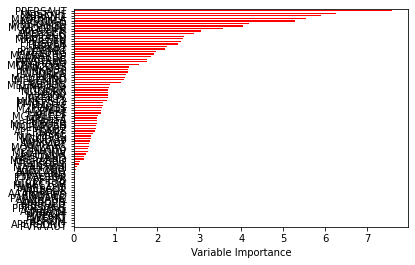

In [72]:
# Using the feature_importances_ attribute of the RandomForestRegressor,
# we can view the importance of each variable:
Importance = pd.DataFrame({'Importance':boosted_caravan.feature_importances_*100}, 
                          index = X_train.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

This is completely unreadable. I should update this to only return the top 10 most important variables.

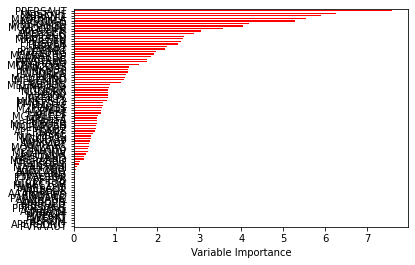

In [73]:
########
#here is another way to calculate the feature importances:
feature_importance = boosted_caravan.feature_importances_*100
rel_imp = pd.Series(feature_importance, 
                    index = X_train.columns).sort_values(inplace = False)
rel_imp.T.plot(kind = 'barh', 
                color = 'r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
########

Instead of doing it that generic way, here is the approach with XGBoost using early stopping to find the optimal number of trees instead of using cross validation.

In [74]:
###XGBoost
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=313)
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            #early stopping
            early_stopping_rounds = 10, #how many rounds after optimal before stopping 
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[0]	validation_0-aucpr:0.13022
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.14189
[2]	validation_0-aucpr:0.12844
[3]	validation_0-aucpr:0.12997
[4]	validation_0-aucpr:0.12004
[5]	validation_0-aucpr:0.12348
[6]	validation_0-aucpr:0.11361
[7]	validation_0-aucpr:0.10838
[8]	validation_0-aucpr:0.11153
[9]	validation_0-aucpr:0.11137
[10]	validation_0-aucpr:0.11259
[11]	validation_0-aucpr:0.11313
Stopping. Best iteration:
[1]	validation_0-aucpr:0.14189



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=313,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=313,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

Interesting, it's claiming that the best number of trees is one.

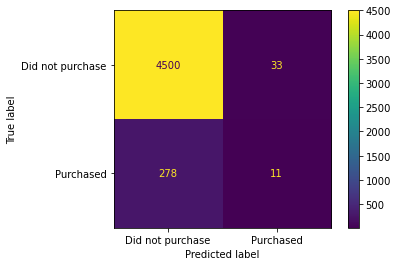

In [75]:
#Build confusion matrix to see how well our XGBoost classification
#model performs on the test data 
plot_confusion_matrix(clf_xgb, 
                      X_test, 
                      y_test,
                      values_format='d',
                      display_labels=["Did not purchase", "Purchased"])

In the confusion matrix we see that of the 4533 customers that did 
not purchase caravan insurance, 4500 (99%) were correctly classified
and of the 289 customers that did not purchase caravan insurance,
11 (3.8%) were correctly classified. <br><br>This indicates that our XGBoost model did not perform well at all. Likely, the biggest reason for this is that our data is severely 
imbalanced and we did nothing to fix it (just took the first 1000 
observations instead of doing something like stratify the data)


XGBoost's scale_pos_weight parameter will help with our imbalanced
data. Instead of using the early stopping approach, we'll actually
use cross validation and GridSearchCV to optimize the parameters. 
<br><br>
In order for XGBoost to give us accurate predictions, we need to make sure that the hyperparameters are dialed in right... parameters like maximum tree depth (max_depth), eta which encourages pruning (gamma), the regularizationparameter lambda (reg_lambda), and the learning 
rate or shrinkage value (learning_rate).
<br><br>
Scott recommended I learn how to use GridSearchCV in his feedback for my midterm project, so here is my attempt. It seems like using GridSearchCV is a good call here since we have multiple hyperparameters that we need to make sure are optimally set. I think using GridSearchCV() is an approach of dialing in the nobs closer to your desired end goal with each iteration, so we'll use that approach by specifying some potential values for the hyperparameters and then GridSearchCV() will give us back the optimal parameters by testing every combination for us.

In [76]:
## ROUND 1
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5] 
}

In [77]:
# To speed up cross validiation and to mitigate overfitting, we are 
# only using a random subset of the data (subsample 90%) and are only 
# using a random subset of the features (colsample_bytree 50%) per tree.
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc', ## see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    verbose=2, # NOTE: If you want to see what Grid Search is doing, set verbose=2...otherwise set to 0
    n_jobs = 10,
    cv = 3
)

optimal_params.fit(X_train, 
                    y_train, 
                    early_stopping_rounds=10,                
                    eval_metric='auc',
                    eval_set=[(X_test, y_test)],
                    verbose=False)
print(optimal_params.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  22 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 264 tasks      | elapsed:    3.9s
[Parallel(n_jobs=10)]: Done 670 tasks      | elapsed:    9.6s
[Parallel(n_jobs=10)]: Done 710 out of 729 | elapsed:   10.1s remaining:    0.3s


{'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'reg_lambda': 1.0, 'scale_pos_weight': 1}


[Parallel(n_jobs=10)]: Done 729 out of 729 | elapsed:   10.4s finished


{'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'reg_lambda': 1.0, 'scale_pos_weight': 1}
<br>
Because gamma and scale_pos_weight were at the ends of their range, we will continue to explore those. max_depth returned 4, which is right in the midle of the range we gave it, so we accept 4 as the optimal depth. Same for learning_rate.

In [78]:
# ## ROUND 2
param_grid = {
    'max_depth': [4],
    'learning_rate': [0.01],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [1.0],
      'scale_pos_weight': [0.5, 1.0, 1.5]
}

In [79]:
# Run this again
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', 
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc', ## see https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    verbose=2, # NOTE: If you want to see what Grid Search is doing, set verbose=2...otherwise set to 0
    n_jobs = 10,
    cv = 3
)

optimal_params.fit(X_train, 
                    y_train, 
                    early_stopping_rounds=10,                
                    eval_metric='auc',
                    eval_set=[(X_test, y_test)],
                    verbose=False)
print(optimal_params.best_params_)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=10)]: Done  22 out of  27 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  27 out of  27 | elapsed:    0.4s finished


{'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'reg_lambda': 1.0, 'scale_pos_weight': 1.0}


Output after running code below: <br>
{'gamma': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'reg_lambda': 1.0, 'scale_pos_weight': 1.0}
<br>
Now we have dialed in gamma and scale_pos_weight to both be 1.0. These are our optimal hypterparameters:
<br>
max_depth=4,learning_rate=0.01,,gamma=1.0,reg_lambda=1.0,scale_pos_weight=1.0

<br>
Now that we have the optimal hyperparemeter values, we can go back and build the final XGBoost model.

In [80]:
#optimal: max_depth=4,learning_rate=0.01,,gamma=1.0,reg_lambda=1.0,scale_pos_weight=1.0
clf_xgb = xgb.XGBClassifier(seed=42,
                        objective='binary:logistic',
                        gamma=1.0,
                        learn_rate=0.01,
                        max_depth=4,
                        reg_lambda=1.0,
                        scale_pos_weight=1.0,
                        subsample=0.9,
                        colsample_bytree=0.5)
clf_xgb.fit(X_train, 
            y_train, 
            verbose=True, 
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

[21:29:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1598185652448/work/src/learner.cc:516: 
Parameters: { learn_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-aucpr:0.11339
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.13009
[2]	validation_0-aucpr:0.14214
[3]	validation_0-aucpr:0.15177
[4]	validation_0-aucpr:0.14992
[5]	validation_0-aucpr:0.15092
[6]	validation_0-aucpr:0.14702
[7]	validation_0-aucpr:0.13902
[8]	validation_0-aucpr:0.14796
[9]	validation_0-aucpr:0.13810
[10]	validation_0-aucpr:0.12842
[11]	validation_0-aucpr:0.12265
[12]	validation_0-aucpr:0.12459
[13]	validation_0-aucpr:0.12038
Stopping. Best iteration:
[3]	validation_0-aucpr:0.15177



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learn_rate=0.01, learning_rate=0.300000012, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1.0,
              scale_pos_weight=1.0, seed=42, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

Interestingly, this shows a message that learning_rate (one of the hyperparameters we dialed in for) might not be used. Regardless, the final output indicates that 3 trees will be best.
<br>

Now that we have fit the optimal model, we can draw another confusion matrix to compare how our new XGBoost model performs against the old one.

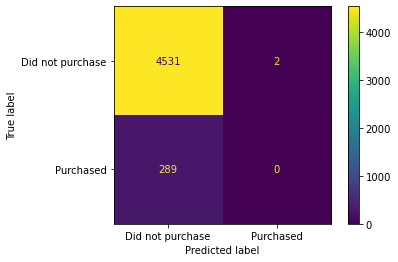

In [81]:
plot_confusion_matrix(clf_xgb, 
                      X_test, 
                      y_test,
                      values_format='d',
                      display_labels=["Did not purchase", "Purchased"])

This performs terribly. At this point I'm actually pretty confused. I expected our XGBoost model to perform well or at least improve somewhat after the adjustments we made. Is our data really too imbalanced to use XGBoost on?

If that's the case, then I'm not going to use XGBoost on the next section and instead use the generic version that we learned in the lab to see if that shows any improvement.
http://www.science.smith.edu/~jcrouser/SDS293/labs/lab14-py.html

## (c) 
Use the boosting model to predict the response on the test data. Predict that a person will make a purchase if the estimated probability of purchase is greater than 20 %. Form a confusion matrix. What fraction of the people predicted to make a purchase do in fact make one? How does this compare with the results obtained from applying KNN or logistic regression to this data set?

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [83]:
# boost model
y_predict_proba = boosted_caravan.predict_proba(X_test)[:,1]
y_pred = np.where(y_predict_proba>0.2, 1, 0)

In [84]:
conf_m1 = pd.DataFrame(confusion_matrix(y_test, y_pred).T, index = ['No', 'Yes'], columns = ['No', 'Yes'])
print(conf_m1)
# percentage of people correctly classified (who were predicted to
# purchase and actually purchase: 38/199 = 19.1%)

       No  Yes
No   4334  251
Yes   199   38


In [85]:
# KNN

for k in range(1,10):
    knn_caravan = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    # y_predict_proba  = knn_caravan.predict_proba(xtest)[:,1]
    y_pred = knn_caravan.predict(X_test)
    
    conf_knn = confusion_matrix(y_test, y_pred) #.T, index = ['No', 'Yes'], columns = ['No', 'Yes']
    print(conf_knn)                 

    #calculate the positive predictive value
    pos_pred_val = np.around(conf_knn[:, 1][1] / np.sum(conf_knn[:, 1]), 5)
    print('Positive Predictive Value: {}'.format(pos_pred_val))

[[4260  273]
 [ 263   26]]
Positive Predictive Value: 0.08696
[[4509   24]
 [ 286    3]]
Positive Predictive Value: 0.11111
[[4463   70]
 [ 279   10]]
Positive Predictive Value: 0.125
[[4515   18]
 [ 285    4]]
Positive Predictive Value: 0.18182
[[4502   31]
 [ 285    4]]
Positive Predictive Value: 0.11429
[[4525    8]
 [ 287    2]]
Positive Predictive Value: 0.2
[[4517   16]
 [ 287    2]]
Positive Predictive Value: 0.11111
[[4528    5]
 [ 287    2]]
Positive Predictive Value: 0.28571
[[4526    7]
 [ 287    2]]
Positive Predictive Value: 0.22222


The predictive power jumps around but generally seems to increase as the number of neighbors increases. Some perform better than the boosted model, some perform worse. They are all generally still pretty terrible models. 